# Proyecto final IDI2

### Introducción

El maíz es uno de los cultivos de granos comestibles más importantes del mundo, utilizado como alimento para humanos y ganado, y como materia prima para diversos productos. Sin embargo, los cultivos de maíz son vulnerables a diversas enfermedades, lo que puede resultar en grandes pérdidas económicas. La detección temprana de enfermedades es clave para el éxito en la agricultura, pero puede ser difícil para los agricultores identificarlas manualmente.

Este trabajo presenta una solución basada en procesamiento de imágenes para la detección automatizada de enfermedades en plantas de maíz. La detección automática de enfermedades de las plantas es esencial para monitorear grandes campos de cultivo y detectar los síntomas de la enfermedad tan pronto como aparezcan. En este trabajo, se utiliza el aprendizaje profundo, una técnica de inteligencia artificial, para detectar automáticamente las enfermedades de las plantas a partir de imágenes de hojas.

### Importando librerías

In [67]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


### Importando imágenes 

In [68]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "archive\data",
    shuffle=True, #las imágenes se mezclarán aleatoriamente antes de dividirlas en lotes.
    image_size=(256, 256), #todas las imágenes se redimensionarán a 256x256 píxeles.
    batch_size=32 # el tamaño del lote para el entrenamiento del modelo.
)

Found 4188 files belonging to 4 classes.


In [69]:
class_names = dataset.class_names
class_names

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']

#### Visualicemos una muestra del lote de imágenes

Este código es una forma útil de visualizar un lote de imágenes y etiquetas en un conjunto de datos de clasificación de imágenes. Esto puede ser útil para verificar si las imágenes se cargan correctamente y si las etiquetas coinciden con las imágenes.

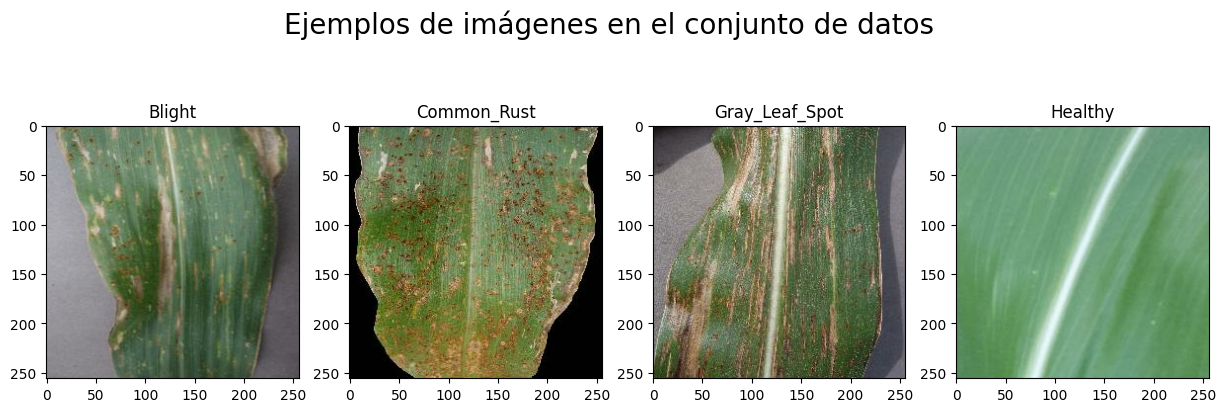

In [70]:
# Obtener una lista de imágenes y etiquetas de la primera época del conjunto de datos
for images, labels in dataset.take(1):
    # Obtener los nombres de las clases del conjunto de datos
    class_names = dataset.class_names
    # Crear una figura con una subfigura para cada clase
    fig, axs = plt.subplots(1, len(class_names), figsize=(15, 5))
    fig.suptitle('Ejemplos de imágenes en el conjunto de datos', fontsize=20)
    # Para cada clase, encontrar la primera imagen en la lista que pertenece a esa clase y mostrarla en la subfigura correspondiente
    for i in range(len(class_names)):
        idx = tf.where(labels == i)[0][0]
        img = images[idx]
        axs[i].imshow(img.numpy().astype("uint8"))
        axs[i].set_title(class_names[i])


### Preprocesamiento y transformaciones

In [71]:
"""
    Divide un conjunto de datos en tres subconjuntos: entrenamiento, validación y prueba,
    utilizando los valores de división proporcionados para cada conjunto.
"""


def get_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True):
    ds_size = len(ds)
    assert train_split + val_split + \
        test_split == 1.0, "Las divisiones deben sumar 1.0."

    if shuffle:
        ds = ds.shuffle(ds_size, reshuffle_each_iteration=False)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds, train_size, val_size, ds_size - train_size - val_size


In [72]:
train_ds, val_ds, test_ds, _, _, _ = get_dataset(dataset)
print(
    f"El tamaño del conjunto de entrenamiento es {len(train_ds)}, el tamaño del conjunto de validación es {len(val_ds)}, y el tamaño del conjunto de prueba es {len(test_ds)}.")


El tamaño del conjunto de entrenamiento es 104, el tamaño del conjunto de validación es 13, y el tamaño del conjunto de prueba es 14.


In [73]:
# optimizaciones adicionales a los conjuntos de datos de entrenamiento, validación y prueba creados por la función get_dataset()
train_ds = train_ds.shuffle(1000).cache().prefetch(
    buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(1000).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(1000).cache().prefetch(buffer_size=tf.data.AUTOTUNE)


* cache(): Almacena en caché los elementos del conjunto de datos en memoria o en disco, lo que permite una recuperación más rápida de los datos durante el entrenamiento.
* shuffle(1000): Baraja aleatoriamente los elementos del conjunto de datos, utilizando un tamaño de búfer de 1000 elementos. La aleatorización puede mejorar la generalización del modelo y evitar que el modelo se sobreajuste a patrones específicos del conjunto de datos.
* prefetch(buffer_size=tf.data.AUTOTUNE): Prefetch los elementos del conjunto de datos para el procesamiento posterior. El tamaño del búfer se establece en tf.data.AUTOTUNE, lo que permite que TensorFlow determine el tamaño óptimo del búfer de acuerdo con la memoria disponible en el sistema y otras consideraciones.

Al aplicar .shuffle() antes de .cache() y .prefetch(), podemos mejorar aún más el rendimiento de los subconjuntos ya que los datos se mezclan antes de ser almacenados en caché y recuperados.

#### Preprocesador de imágenes

In [74]:
# Usa dos capas secuenciales para cambiar el tamaño de las imágenes y ajustar sus valores de píxel a un rango entre 0 y 1.
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256, 256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])


Estas capas de preprocesamiento son útiles para normalizar las imágenes de entrada antes de que se alimenten a la CNN para su entrenamiento. Al normalizar las imágenes, los valores de píxel se ajustan a un rango común, lo que ayuda a la CNN a aprender patrones y características importantes de manera más efectiva.

#### Aumentación de datos

La aumentación de datos se refiere a la aplicación de transformaciones aleatorias a las imágenes para crear nuevas variaciones de las mismas. Esto puede mejorar la capacidad de generalización de la CNN y reducir el sobreajuste.

In [75]:
data_augmentation = tf.keras.Sequential([
    # Voltear aleatoriamente horizontalmente y verticalmente las imágenes
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    # Rotar aleatoriamente las imágenes en un ángulo de hasta 0.2 radianes
    layers.experimental.preprocessing.RandomRotation(0.2),
])


### Modelo CNN

In [76]:
n_classes = 4
# tiene 4 neuronas, y produce una distribución de probabilidad sobre las clases.
output_layer = layers.Dense(n_classes, activation='softmax')
# espera un lote de imágenes de tamaño 256x256 con 3 canales de color (RGB).
input_shape = (32, 256, 256, 3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    # 5 capas convolucionales
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    # cada capa convolucional va seguida de una de agrupación
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),  # aplana los mapas de características en un vector de una dimensión
    layers.Dense(64, activation='relu'),
    output_layer

])
model.build(input_shape=input_shape)


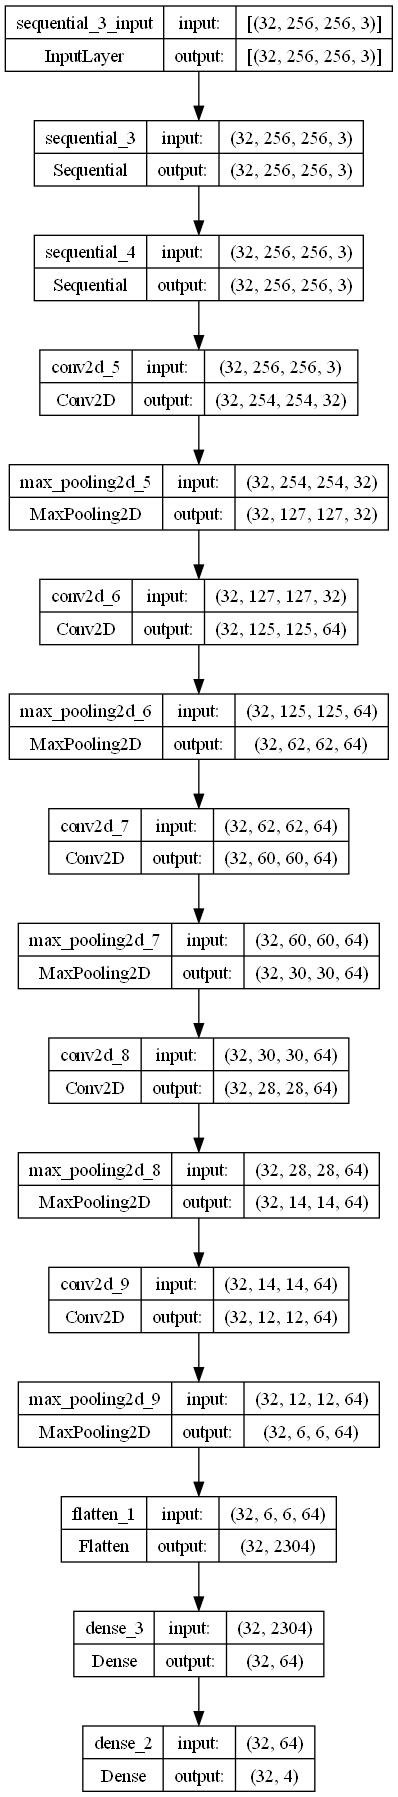

In [77]:
plot_model(model, to_file='model.png', show_shapes=True,
           show_layer_names=True, rankdir='TB')


Ahora vamos a compilar el modelo antes de entrenarlo con datos. La función compile() permite configurar varios aspectos del proceso de entrenamiento del modelo, incluyendo el optimizador, la función de pérdida y las métricas de evaluación.

In [78]:
model.compile(
    optimizer='RMSProp',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


RMSProp es un optimizador popular utilizado en el aprendizaje profundo para actualizar los pesos de la red neuronal durante el entrenamiento. Es una variante del algoritmo de descenso de gradiente estocástico (SGD) que adapta la tasa de aprendizaje de cada peso en función de su historial de gradientes.

La función de pérdida elegida es la entropía cruzada categórica escasa, que es adecuada para problemas de clasificación multiclase donde cada ejemplo puede tener solo una etiqueta verdadera. La opción **from_logits=False** indica que el modelo produce una distribución de probabilidad directamente, en lugar de salidas lineales (logits) que deben transformarse con una función de activación softmax

### Entrenamiento del modelo CNN

Este método entrena el modelo en los datos de entrenamiento durante un número fijo de épocas y devuelve un objeto History que contiene información sobre la evolución de la función de pérdida y las métricas de entrenamiento y validación a lo largo del tiempo.

In [79]:
history = model.fit(
    train_ds,
    epochs=45,
    batch_size=32,
    verbose=1,
    validation_data=val_ds)


Epoch 1/45
104/104 [==============================] - 166s 2s/step - loss: 1.0155 - accuracy: 0.6011 - val_loss: 0.8053 - val_accuracy: 0.6514
Epoch 2/45
104/104 [==============================] - 165s 2s/step - loss: 0.5753 - accuracy: 0.7915 - val_loss: 0.8195 - val_accuracy: 0.7260
Epoch 3/45
104/104 [==============================] - 159s 2s/step - loss: 0.4454 - accuracy: 0.8189 - val_loss: 0.4206 - val_accuracy: 0.8486
Epoch 4/45
104/104 [==============================] - 154s 1s/step - loss: 0.4051 - accuracy: 0.8342 - val_loss: 0.3079 - val_accuracy: 0.8846
Epoch 5/45
104/104 [==============================] - 164s 2s/step - loss: 0.3846 - accuracy: 0.8439 - val_loss: 0.2651 - val_accuracy: 0.8918
Epoch 6/45
104/104 [==============================] - 164s 2s/step - loss: 0.3439 - accuracy: 0.8595 - val_loss: 1.4505 - val_accuracy: 0.6418
Epoch 7/45
104/104 [==============================] - 162s 2s/step - loss: 0.3330 - accuracy: 0.8721 - val_loss: 1.3029 - val_accuracy: 0.6611

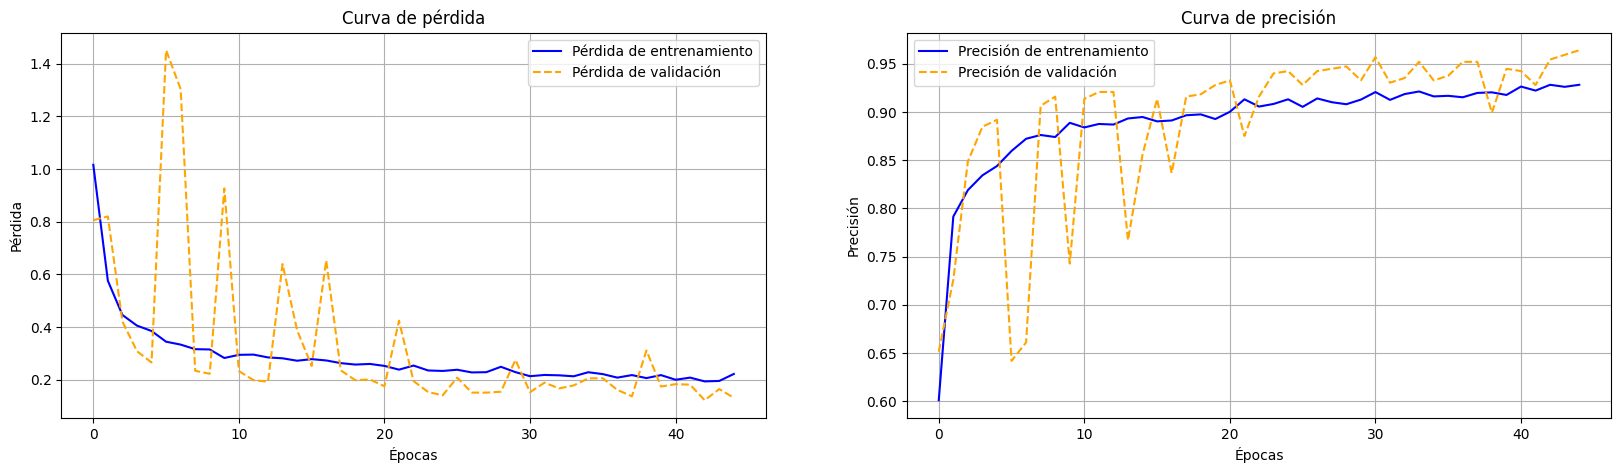

In [81]:
his_data = pd.DataFrame(history.history)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

ax[0].plot(his_data.loss, label="Pérdida de entrenamiento",
           color='blue', linestyle='-')
ax[0].plot(his_data.val_loss, label="Pérdida de validación",
           color='orange', linestyle='--')
ax[0].set(xlabel="Épocas", ylabel="Pérdida", title="Curva de pérdida")
ax[0].grid()
ax[0].legend()

ax[1].plot(his_data.accuracy, label="Precisión de entrenamiento",
           color='blue', linestyle='-')
ax[1].plot(his_data.val_accuracy, label="Precisión de validación",
           color='orange', linestyle='--')
ax[1].set(xlabel="Épocas", ylabel="Precisión", title="Curva de precisión")
ax[1].grid()
ax[1].legend()

plt.show()


Ejecutamos el modelo en el conjunto de datos de prueba

In [80]:
# devuelve la pérdida y la precisión en los datos de prueba
eval_test = model.evaluate(test_ds)


14/14 [==============================] - 15s 286ms/step - loss: 0.2303 - accuracy: 0.9397


### Predicción/diagnóstico 

In [82]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)  # probabilidades para cada clase
    # la etiqueta se determina tomando el índice de la clase con la probabilidad más alta utilizando la función argmax
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)

    return predicted_class, confidence


La **matriz de confusión** mostrará el número de veces que cada etiqueta predicha coincidió o no coincidió con la etiqueta real. La diagonal principal muestra las predicciones correctas, mientras que las celdas fuera de la diagonal principal muestran las 

1/1 [==============================] - 0s 26ms/step


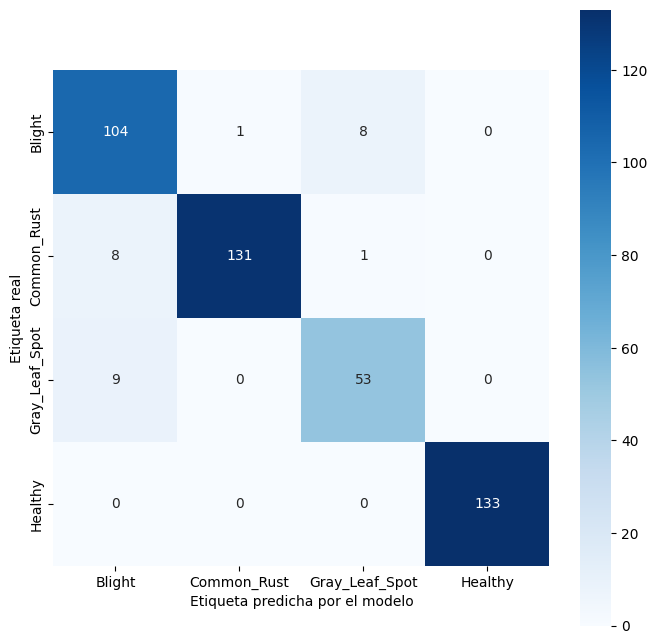

In [83]:
# crear listas para las predicciones y etiquetas reales
predicted_labels = []
true_labels = []

# iterar sobre todo el conjunto de prueba
for images, labels in test_ds:
    for i in range(len(labels)):
        # hacer la predicción para la imagen actual
        predicted_class, _ = predict(model, images[i].numpy())

        # agregar la etiqueta predicha y verdadera a las listas correspondientes
        predicted_labels.append(predicted_class)
        true_labels.append(class_names[labels[i]])

# generar la matriz de confusión
cm = confusion_matrix(true_labels, predicted_labels)

# visualizar la matriz de confusión
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, square=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta predicha por el modelo')
plt.ylabel('Etiqueta real')
plt.show()


1/1 [==============================] - 0s 26ms/step


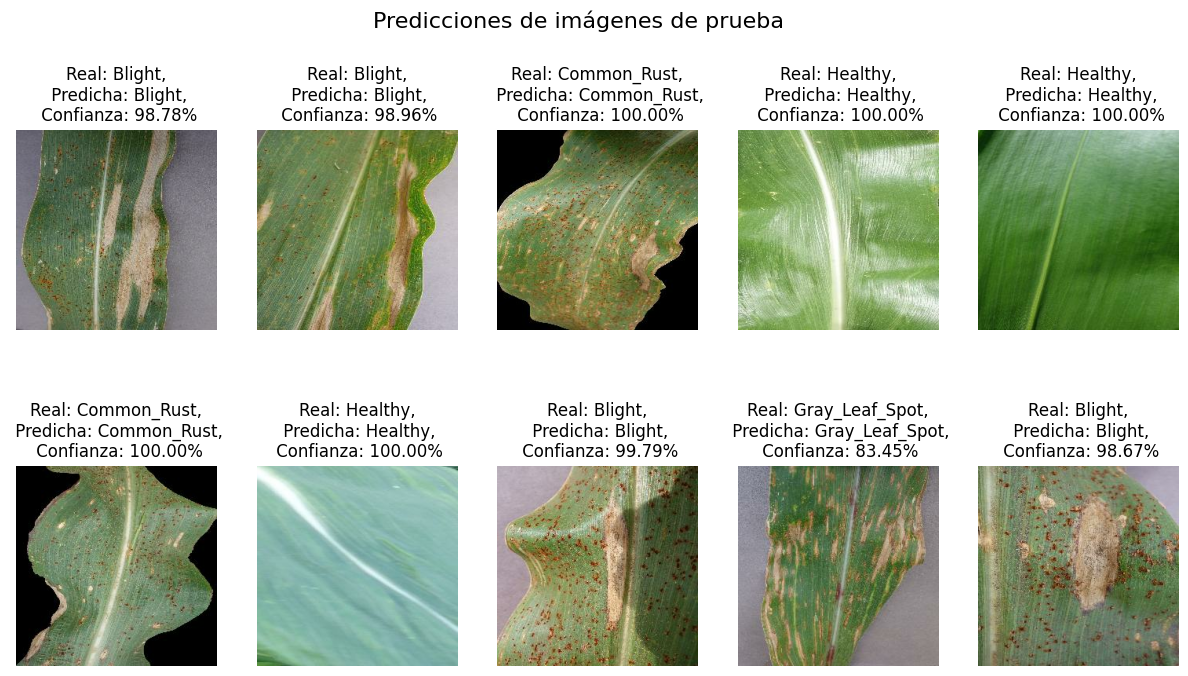

In [84]:
plt.figure(figsize=(15, 8))
plt.suptitle("Predicciones de imágenes de prueba", fontsize=16)
for images, labels in test_ds.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        if confidence <= 60:
            title_color = 'red'
        else:
            title_color = 'black'

        plt.title(f"Real: {actual_class},\n Predicha: {predicted_class},\n Confianza: {confidence:.2f}%",
                  color=title_color)
        plt.axis("off")


In [85]:
model.save('Proyecto final/model_1')


INFO:tensorflow:Assets written to: Proyecto final/model_1\assets


INFO:tensorflow:Assets written to: Proyecto final/model_1\assets
